# Wildfire Data Extraction - Del Rio, Texas

This code is used to extract the fires data from the wildfire dataset and filtering it based on certain conditions using the city assigned. The purpose of this code  to  find the fires which  are within 1250 miles of the assigned city.
My Assigned City: Del Rio, Texas

The data extraction code extracts data from the USGS Wildfire data and I found that there are 70861 fires which are  under 1250 miles from Del Rio based on distance.

I have used the sample code from the notebook provided by Prof as a reference to carry out the below tasks.

## Import Libraries

In [186]:
import pandas as  pd
import plotly.express as px
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of California wildfires extracted from the main wildfire dataset.
#
import geojson
import concurrent.futures

## Data Extraction

Defining file path which is downloaded from https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81

File: USGS_Wildland_Fire_Combined_Dataset.json

Also defining the Latitude and Longitude for my assigned city: Del Rio Texas

In [190]:
# Data path
DATA_FILE = os.path.join("/Users/stlp/Documents/DATA-512/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json")
print(f"{DATA_FILE=}")

# Defining Lat Lon for my city
Del_Rio_Lat_Lon = (29.3692, -100.8908)

DATA_FILE='/Users/stlp/Documents/DATA-512/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'


Geojson to read the data and counting the number of features/fires in the Data

In [3]:
geojson_file = open(DATA_FILE,"r")
gj_data = geojson.load(geojson_file)
geojson_file.close()
#
#    Print the keys and number of features from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)

print("\nFound "+str(len(gj_data['features']))+" features in the variable gj_data")

The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']

Found 135061 features in the variable gj_data


Defining functions to calculate the rings and distance of fires from the desired US city  

In [4]:
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

Extracting the fires specific to 3 filters:
1. The estimate only considers the last 60 years of wildland fires (1963-2023).
2. The estimate only considers fires that are within 1250 miles of your assigned city.
3. An annual fire season will run from May 1st through October 31st.

The features are appended into the list based on these filters for my city: Del Rio

In [ ]:
del_rio_features = list()
excluded_list = list()

def calculate_closest_distance(wf_feature):
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    ring_data = wf_feature['geometry']['rings'][0]

    if wf_year >= 1963:
        distance = shortest_distance_from_place_to_fire_perimeter(Del_Rio_Lat_Lon, ring_data)
        # print(f"The closest distance of fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was {distance[0]:1.2f} miles to Del Rio")

        if distance[0] <= 1250:
            wf_feature['attributes']['fire_lat'] = distance[1][0]
            wf_feature['attributes']['fire_lon'] = distance[1][1]
            wf_feature['attributes']['distance_from_del_rio'] = distance[0]
            del_rio_features.append(wf_feature)


with concurrent.futures.ThreadPoolExecutor(100) as executor:
    # Submit each fire feature for calculation
    future_to_feature = {executor.submit(calculate_closest_distance, wf_feature): wf_feature for wf_feature in gj_data['features']}

    # Wait for all calculations to complete
    for future in concurrent.futures.as_completed(future_to_feature):
        feature = future_to_feature[future]
        try:
            future.result()  # Get the result of the calculation
        except Exception as exc:
            print(f"Calculation for feature {feature} raised an exception: {exc}")

## Data Save

Saving the extracted featurs/fires in JSON format

In [8]:
import json
with open('/Users/stlp/Documents/DATA-512/del_rio_fires.json', 'w') as fout:
    json.dump(del_rio_features , fout)

Counting the number of fires within 1250 miles which started after 1963. I found there are 70861 fires based on my city Del Rio in Texas.

In [9]:
len(del_rio_features)

70861

Getting the JSON features into a dataframe using for loop to append individual features and its attributres. 

In [25]:
del_rio_fires_df = pd.DataFrame()
for i in range(len(del_rio_features)):
    if(i%10000 == 0):
        print(i)
    del_rio_fires_df = pd.concat([del_rio_fires_df, pd.DataFrame([del_rio_features[i]['attributes']])])

0
10000
20000
30000
40000
50000
60000
70000


In [193]:
del_rio_fires_df = del_rio_fires_df.reset_index(drop=True)
del_rio_fires_df.head(10)

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,fire_lat,fire_lon,distance_from_del_rio,smoke_estimate
0,14306,14306,Wildfire,1963,1,"1 (1), 3 (1)",4995.253626,2021.507422,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,"Caution, this Wildfire in 1963 overlaps with a...",0.994707,1,Yes,15980.673439,2.021507e+07,36.475031,-106.702400,594.570587,84.014476
1,14305,14305,Wildfire,1963,1,"1 (3), 3 (3)",4995.910129,2021.773099,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (6),...,None,0.994948,1,Yes,15979.785579,2.021773e+07,35.678581,-106.479715,543.334644,91.949044
2,14341,14341,Wildfire,1963,1,"1 (2), 3 (2)",647.246513,261.931371,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (4),...,None,0.272200,None,No,10996.509615,2.619314e+06,43.526843,-103.471741,986.598492,6.560384
3,14308,14308,Wildfire,1963,1,"1 (1), 3 (2)",4293.410613,1737.481631,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (2)",...,None,0.344648,None,No,25169.664017,1.737482e+07,43.154410,-113.233561,1171.237153,36.657056
4,14324,14324,Wildfire,1963,1,"1 (1), 3 (3)",1552.699889,628.355352,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (3), Likely Wildfire (1)",...,None,0.709395,None,No,10550.269932,6.283554e+06,34.728314,-119.946244,1175.406549,13.209897
5,14343,14343,Wildfire,1963,1,"1 (1), 3 (2)",632.343510,255.900339,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (2)",...,None,0.432292,None,No,8624.859107,2.559003e+06,42.892318,-114.093802,1186.287077,5.330443
6,14312,14312,Wildfire,1963,1,"1 (1), 3 (2)",2840.558722,1149.533331,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (2)",...,None,0.535192,None,No,16428.993577,1.149533e+07,43.988438,-111.669798,1170.063244,24.276967
7,14323,14323,Wildfire,1963,1,"1 (1), 3 (2)",1562.805612,632.444993,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (2)",...,None,0.705143,None,No,10616.410202,6.324450e+06,43.261508,-113.692527,1191.857611,13.112352
8,14326,14326,Wildfire,1963,1,"1 (1), 3 (2)",1528.187835,618.435676,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (2)",...,None,0.596885,None,No,11410.557262,6.184357e+06,42.491152,-113.244755,1136.807835,13.442798
9,14369,14369,Wildfire,1963,1,"1 (2), 3 (6)",359.191740,145.359740,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (2)",...,None,0.420387,None,No,6591.775927,1.453597e+06,33.884689,-116.771532,985.255672,3.645670


Saving the dataframe as CSV for further analysis

In [28]:
del_rio_fires_df.to_csv("del_rio_fires_df.csv")

In [100]:
del_rio_fires_df.describe()

,OBJECTID,USGS_Assigned_ID,Fire_Year,Fire_Polygon_Tier,GIS_Acres,GIS_Hectares,Circleness_Scale,Shape_Length,Shape_Area,fire_lat,fire_lon,distance_from_del_rio,smoke_estimate
count,70861.000000,70861.000000,70861.000000,70861.000000,7.086100e+04,7.086100e+04,70861.000000,7.086100e+04,7.086100e+04,70861.000000,70861.000000,70861.000000,7.086100e+04
mean,72207.062799,72207.062799,2003.644628,2.884196,1.788710e+03,7.238653e+02,0.471217,1.188840e+04,7.238653e+06,36.498640,-102.458844,910.914087,6.961608e+00
std,32845.279641,32845.279641,13.724469,2.452673,1.263020e+04,5.111262e+03,0.261127,7.499986e+04,5.111262e+07,4.669699,12.727054,273.895628,3.110354e+02
min,14304.000000,14304.000000,1963.000000,1.000000,6.558795e-07,2.654250e-07,0.000051,1.212677e+00,2.654250e-03,24.671056,-121.001852,28.803066,7.313591e-10
25%,44065.000000,44065.000000,1996.000000,1.000000,1.280371e+01,5.181479e+00,0.262550,1.133512e+03,5.181479e+04,33.538415,-113.798435,698.491282,1.596669e-02
50%,73113.000000,73113.000000,2008.000000,1.000000,1.179990e+02,4.775249e+01,0.435511,3.933408e+03,4.775249e+05,36.015440,-105.456179,977.185558,1.487109e-01
75%,100792.000000,100792.000000,2014.000000,6.000000,9.972989e+02,4.035925e+02,0.647025,1.246434e+04,4.035925e+06,39.680282,-91.351740,1148.241019,1.257193e+00
max,135060.000000,135060.000000,2020.000000,8.000000,1.566273e+06,6.338483e+05,0.999917,1.757948e+07,6.338483e+09,47.462191,-80.183831,1249.996926,7.898325e+04


In [105]:
del_rio_fires_df['smoke_estimate'] = (del_rio_fires_df['GIS_Acres']/del_rio_fires_df['distance_from_del_rio'])*10
del_rio_fires_df

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,fire_lat,fire_lon,distance_from_del_rio,smoke_estimate
0,14306,14306,Wildfire,1963,1,"1 (1), 3 (1)",4995.253626,2021.507422,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,"Caution, this Wildfire in 1963 overlaps with a...",0.994707,1,Yes,15980.673439,2.021507e+07,36.475031,-106.702400,594.570587,84.014476
1,14305,14305,Wildfire,1963,1,"1 (3), 3 (3)",4995.910129,2021.773099,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (6),...,None,0.994948,1,Yes,15979.785579,2.021773e+07,35.678581,-106.479715,543.334644,91.949044
2,14341,14341,Wildfire,1963,1,"1 (2), 3 (2)",647.246513,261.931371,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (4),...,None,0.272200,None,No,10996.509615,2.619314e+06,43.526843,-103.471741,986.598492,6.560384
3,14308,14308,Wildfire,1963,1,"1 (1), 3 (2)",4293.410613,1737.481631,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (2)",...,None,0.344648,None,No,25169.664017,1.737482e+07,43.154410,-113.233561,1171.237153,36.657056
4,14324,14324,Wildfire,1963,1,"1 (1), 3 (3)",1552.699889,628.355352,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (3), Likely Wildfire (1)",...,None,0.709395,None,No,10550.269932,6.283554e+06,34.728314,-119.946244,1175.406549,13.209897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70856,134907,134907,Prescribed Fire,2019,8,8 (1),925.983806,374.732351,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,"Caution, this Prescribed Fire in 2019 overlaps...",0.219853,None,No,14635.208333,3.747324e+06,44.697188,-112.893583,1244.939540,7.437982
70857,134363,134363,Prescribed Fire,2014,8,8 (1),23.962644,9.697338,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,"Caution, this Prescribed Fire in 2014 overlaps...",0.396226,None,No,1753.718868,9.697338e+04,35.032196,-116.365728,985.566549,0.243136
70858,134408,134408,Prescribed Fire,2015,8,8 (1),7462.879281,3020.120095,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,"Caution, this Prescribed Fire in 2015 overlaps...",0.078592,None,No,69490.727133,3.020120e+07,40.795455,-108.772422,904.534518,82.505191
70859,133523,133523,Prescribed Fire,2008,8,8 (1),61.622919,24.937911,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,"Caution, this Prescribed Fire in 2008 overlaps...",0.000051,None,No,248238.555706,2.493791e+05,42.736500,-115.017516,1210.996793,0.508861


In [109]:
del_rio_fires_df_annual =  del_rio_fires_df.groupby('Fire_Year').agg(sum_smoke_estimate=('smoke_estimate','sum'), avg_smoke_estimate=('smoke_estimate','mean')).reset_index()
del_rio_fires_df_annual

,Fire_Year,sum_smoke_estimate,avg_smoke_estimate
0,1963,800.822591,3.364801
1,1964,2359.505274,12.418449
2,1965,591.580867,2.830530
3,1966,4312.369918,16.459427
4,1967,2520.693706,9.067244
5,1968,2216.740562,8.796590
6,1969,1431.428473,6.333754
7,1970,6707.143046,17.242013
8,1971,5259.289984,14.983732
9,1972,2947.765597,9.269703


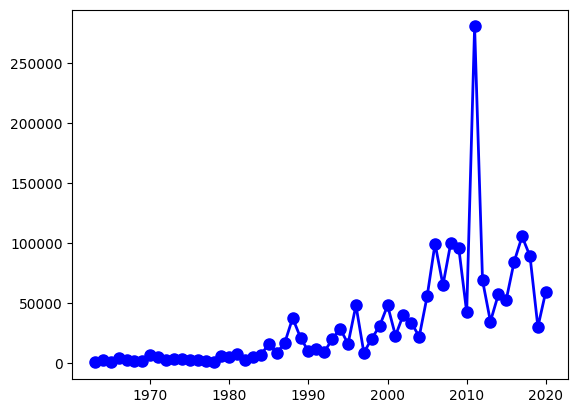

In [107]:
# plt.linechart(del_rio_fires_df_annual['Fire_Year'],del_rio_fires_df_annual['sum_smoke_estimate'])
plt.plot(del_rio_fires_df_annual['Fire_Year'],
         del_rio_fires_df_annual['sum_smoke_estimate'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)


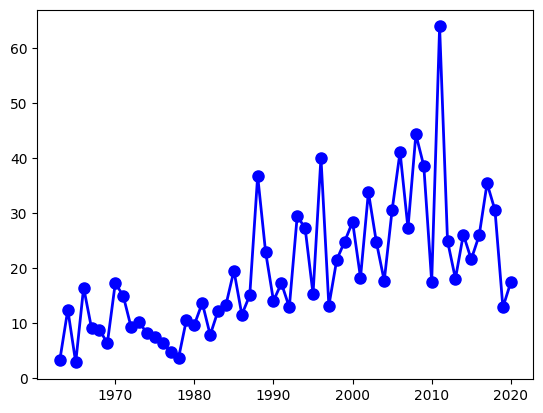

In [108]:
plt.plot(del_rio_fires_df_annual['Fire_Year'],
         del_rio_fires_df_annual['avg_smoke_estimate'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)


In [77]:
final_aqi_df = pd.read_csv('final_aqi.csv',index_col=False)
final_aqi_df

,Unnamed: 0,date_local,pollutant_standard,aqi
0,0,1988-03-02,NaN,20.0
1,1,1988-03-05,NaN,18.0
2,2,1988-03-09,NaN,23.0
3,3,1988-03-16,NaN,46.0
4,4,1988-03-19,NaN,11.0
...,...,...,...,...
53553,2530,2022-12-19,NaN,14.0
53554,2531,2022-12-22,NaN,20.0
53555,2532,2022-12-25,NaN,11.0
53556,2533,2022-12-28,NaN,16.0


In [127]:
aqi = final_aqi_df.groupby('date_local')['aqi'].max().reset_index()
aqi['year'] = pd.to_datetime(aqi['date_local']).dt.year
aqi_per_year = aqi.groupby('year')['aqi'].apply(lambda group: group.nlargest(30).mean()).reset_index()
aqi_per_year

,year,aqi
0,1988,39.300000
1,1989,42.133333
2,1990,43.333333
3,1991,38.333333
4,1992,32.966667
5,1993,39.566667
6,1994,40.066667
7,1995,39.000000
8,1996,42.133333
9,1997,40.666667


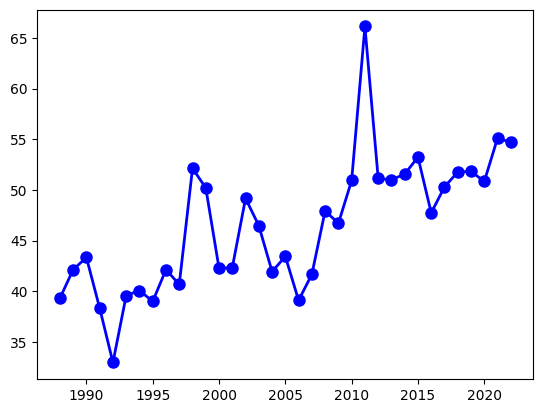

In [128]:
plt.plot(aqi_per_year['year'],
         aqi_per_year['aqi'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

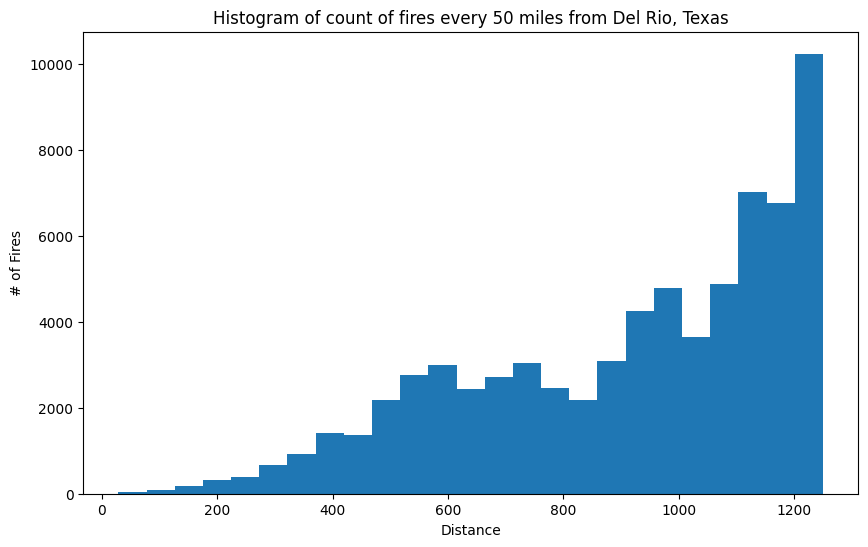

In [140]:
plt.figure(figsize=(10, 6)) 

bin_width = 50
data_range = max(del_rio_fires_df['distance_from_del_rio']) - min(del_rio_fires_df['distance_from_del_rio'])
num_bins = int(data_range / bin_width)

plt.hist(del_rio_fires_df['distance_from_del_rio'],bins=25)
# Customize the chart
plt.title('Histogram of count of fires every 50 miles from Del Rio, Texas')
plt.xlabel('Distance')
plt.ylabel('# of Fires')

# Display the chart
plt.show()

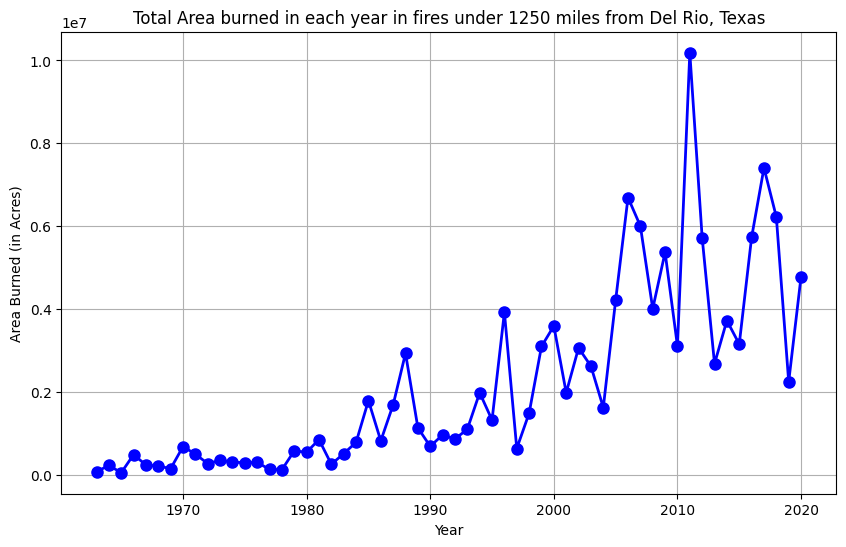

In [145]:
area_burned = del_rio_fires_df.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

plt.figure(figsize=(10, 6)) 

# Create a line chart for the second line
plt.plot(area_burned['Fire_Year'], area_burned['GIS_Acres'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Total Area burned in each year in fires under 1250 miles from Del Rio, Texas')
plt.xlabel('Year')
plt.ylabel('Area Burned (in Acres)')

# Display the chart
plt.grid(True)
plt.show()

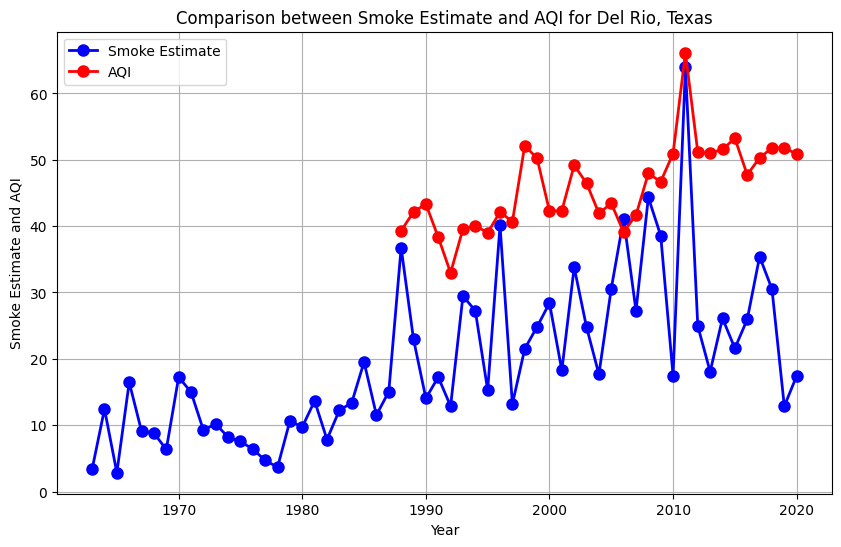

In [147]:
smoke_aqi = pd.merge(del_rio_fires_df_annual,aqi_per_year,how="left",left_on="Fire_Year",right_on="year")

plt.figure(figsize=(10, 6)) 
plt.plot(smoke_aqi['Fire_Year'], smoke_aqi['avg_smoke_estimate'], label='Smoke Estimate', marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Create a line chart for the second line
plt.plot(smoke_aqi['Fire_Year'], smoke_aqi['aqi'], label='AQI', marker='o', color='r', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Comparison between Smoke Estimate and AQI for Del Rio, Texas')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate and AQI')
plt.legend()  # Add a legend to distinguish the two lines

# Display the chart
plt.grid(True)
plt.show()

In [ ]:
# fig = px.histogram(del_rio_fires_df, x="distance_from_del_rio",nbins=20)
# fig.update_layout(
#     width=1000,
#     height=800,
# )
# fig.show()

# Predictive Model

In [152]:
# Load your data
data = pd.Series(del_rio_fires_df_annual['avg_smoke_estimate'])  

model = pm.auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True,
                   error_action="ignore", max_order=None, trace=True, information_criterion='bic')

# Get the best order (p, d, q) determined by auto_arima
best_order = model.get_params()['order']

print("Best (p, d, q) order:", best_order)


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=438.210, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=461.094, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=445.715, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=430.000, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=457.072, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=433.003, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=432.499, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=436.327, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=427.564, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=429.941, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=429.137, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=441.703, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=432.753, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.732 seconds
Best (p, d, q) order: (0, 1, 1)


In [185]:
# Fit ARIMA model
model = ARIMA(data, order=(4,2,3))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=25)
predictions_data = pd.DataFrame({'Year': range(2021, 2046), 'Predictions': predictions})

print("AIC : "+str(model_fit.aic)+" BIC : "+str(model_fit.bic))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



AIC : 428.72015890632406 BIC : 444.92297243220526


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [182]:
predictions_data

,Year,Predictions
58,2021,22.495272
59,2022,13.103110
60,2023,20.878896
61,2024,21.902073
62,2025,14.219547
63,2026,20.568592
64,2027,22.551915
65,2028,16.336029
66,2029,19.693424
67,2030,22.739862


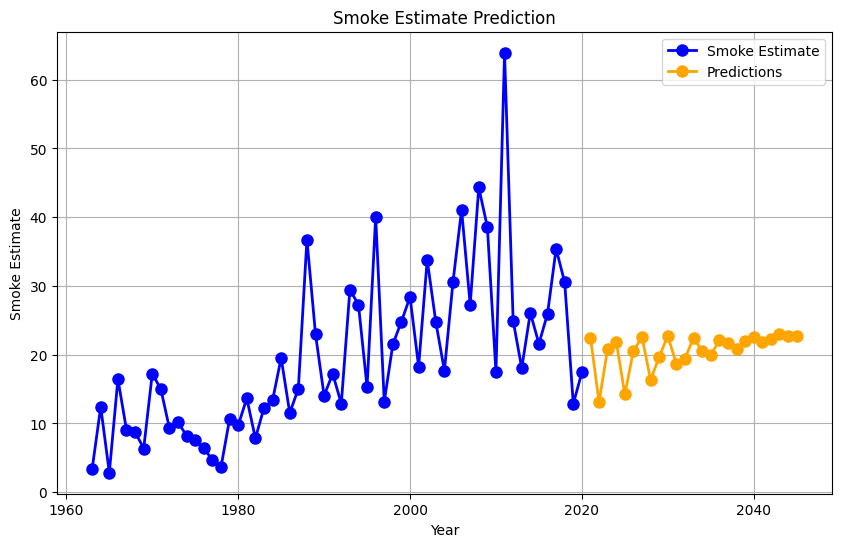

In [183]:
plt.figure(figsize=(10, 6)) 
plt.plot(del_rio_fires_df_annual['Fire_Year'], del_rio_fires_df_annual['avg_smoke_estimate'], label='Smoke Estimate', marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Create a line chart for the second line
plt.plot(predictions_data['Year'], predictions_data['Predictions'], label='Predictions', marker='o', color='orange', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Smoke Estimate Prediction')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()  # Add a legend to distinguish the two lines

# Display the chart
plt.grid(True)
plt.show()